🔄 Cargando modelo...
✅ Modelo cargado en: cuda

📊 Test set: 4128 samples

🔄 Haciendo predicciones en test set...
✅ Predicciones completadas

📈 MÉTRICAS GENERALES

Accuracy:  0.9213 (92.13%)
Precision: 0.9096
Recall:    0.9356
F1-Score:  0.9224

              precision    recall  f1-score   support

        Fake     0.9337    0.9070    0.9201      2064
        Real     0.9096    0.9356    0.9224      2064

    accuracy                         0.9213      4128
   macro avg     0.9216    0.9213    0.9213      4128
weighted avg     0.9216    0.9213    0.9213      4128



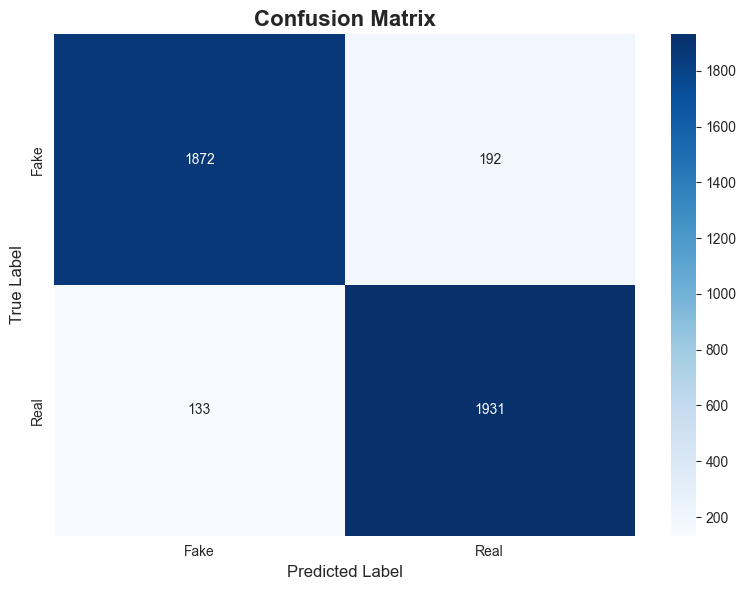


✅ Confusion matrix guardada en: results/confusion_matrix.png


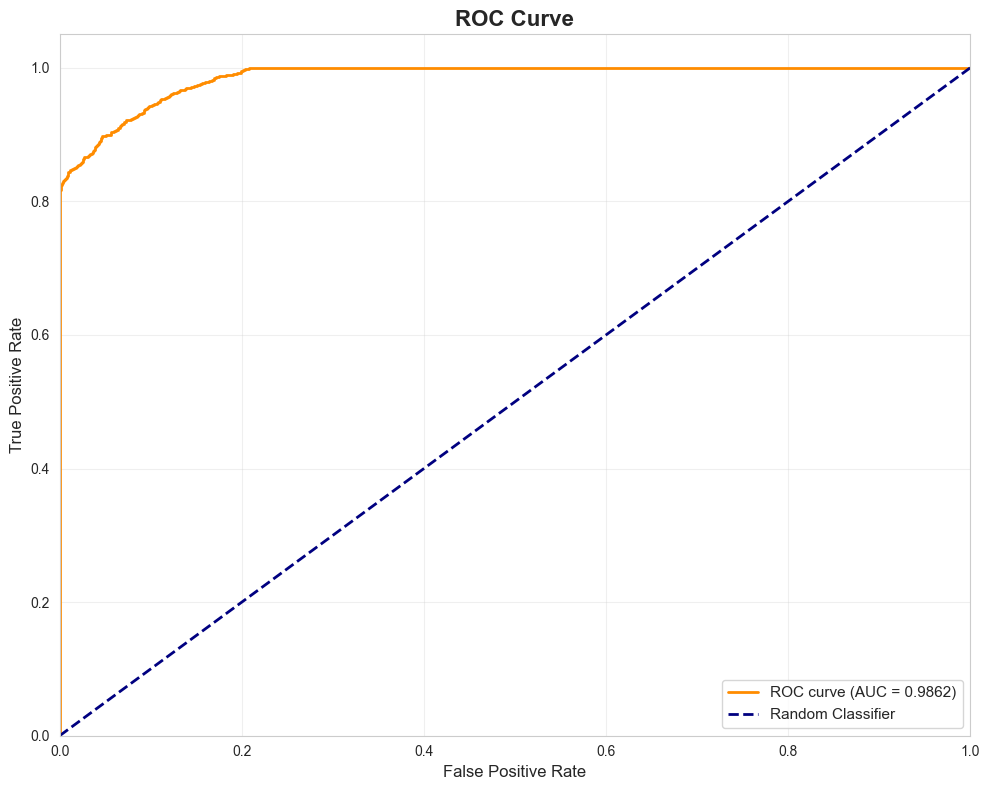

✅ ROC curve guardada en: results/roc_curve.png
📊 AUC Score: 0.9862


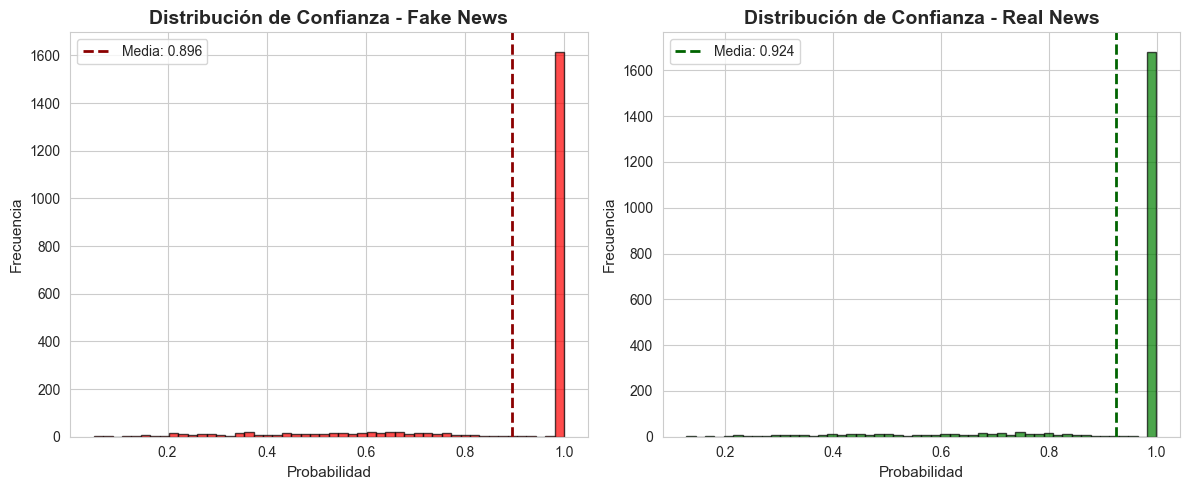

✅ Distribución de confianza guardada en: results/confidence_distribution.png

🔍 ANÁLISIS DE ERRORES

❌ Falsos Positivos: 192

Ejemplos de Falsos Positivos (predijo Real cuando era Fake):

5. Confianza: 61.4%
   Texto: We have drawn down to presurge levels. Basra, Mosul and now Sadr City are quiet and its long and its tough and there will be setbacks. Greensdale, Wis....

10. Confianza: 80.7%
   Texto: Were 15 trillion now in debt, with a president thats racked up as much debt as almost all of the other presidents combined. a Republican presidential debate in Sioux City, Iowa...

28. Confianza: 51.0%
   Texto: I was able to go and buy an automatic weapon Most people can go out and buy an automatic weapon. a live broadcast on CNN...

❌ Falsos Negativos: 133

Ejemplos de Falsos Negativos (predijo Fake cuando era Real):

37. Confianza: 61.7%
   Texto: Dodd brought both parties together to pass the Family and Medical Leave Act. a TV ad airing in Iowa and New Hampshire....

46. Confianza: 70

C:\Users\pablo\AppData\Local\Temp\ipykernel_448\3350241622.py:240: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_length = test_df.groupby('length_bin')['correct'].mean()


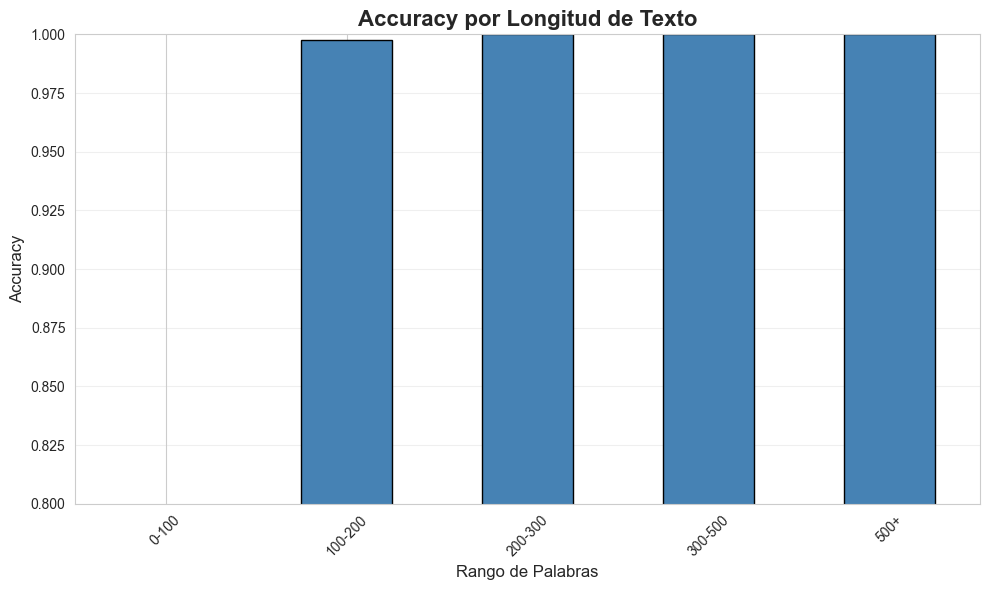


📊 Accuracy por longitud de texto:
length_bin
0-100      0.700555
100-200    0.997481
200-300    1.000000
300-500    1.000000
500+       1.000000
Name: correct, dtype: float64


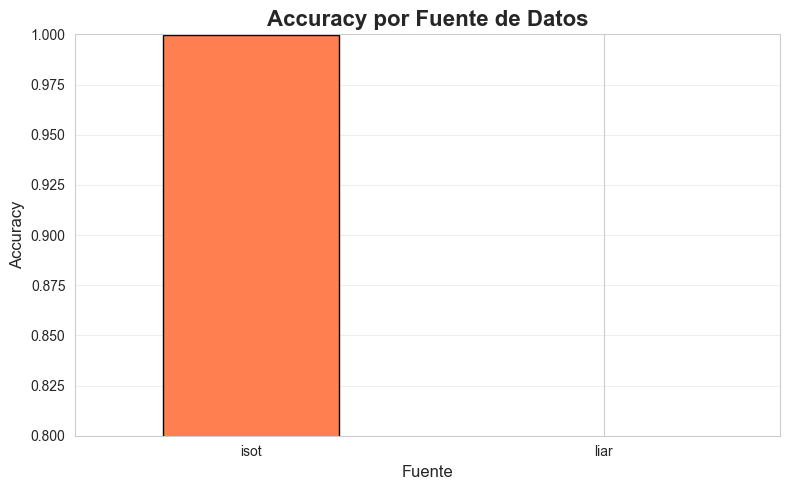


📊 Accuracy por fuente:
source
isot    0.999698
liar    0.604396
Name: correct, dtype: float64

🧪 PRUEBAS CON EJEMPLOS PERSONALIZADOS

1. Texto: Breaking: Scientists discover cure for cancer in revolutionary study published today.
   Predicción: Fake
   Confianza: 70.36%
   Prob(Fake)=70.4% | Prob(Real)=29.6%

2. Texto: You won't believe what this celebrity did! Doctors hate this one weird trick!
   Predicción: Fake
   Confianza: 83.96%
   Prob(Fake)=84.0% | Prob(Real)=16.0%

3. Texto: The Federal Reserve announced interest rate changes during today's meeting.
   Predicción: Real
   Confianza: 53.91%
   Prob(Fake)=46.1% | Prob(Real)=53.9%

4. Texto: Aliens confirmed to have visited Earth, says anonymous government source.
   Predicción: Fake
   Confianza: 63.58%
   Prob(Fake)=63.6% | Prob(Real)=36.4%

5. Texto: New research from MIT shows promising results in renewable energy technology.
   Predicción: Fake
   Confianza: 58.05%
   Prob(Fake)=58.0% | Prob(Real)=42.0%

✅ EVALUACIÓN COMPL

In [5]:
# ============================================
# NOTEBOOK: Evaluación Completa del Modelo BERT
# ============================================
# Guarda este código como: notebooks/05_evaluate_bert_model.ipynb

import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ============================================
# 1. CARGAR MODELO ENTRENADO
# ============================================

MODEL_PATH = '../models/bert_fakenews_v1'

print("🔄 Cargando modelo...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

print(f"✅ Modelo cargado en: {device}")

# ============================================
# 2. CARGAR DATOS DE TEST
# ============================================

test_df = pd.read_csv('../data/final/test_final.csv')
print(f"\n📊 Test set: {len(test_df)} samples")

# ============================================
# 3. FUNCIÓN DE PREDICCIÓN
# ============================================

def predict_batch(texts, batch_size=32):
    """
    Predice en batch para eficiencia
    """
    predictions = []
    probabilities = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    
    return np.array(predictions), np.array(probabilities)

# ============================================
# 4. HACER PREDICCIONES EN TEST SET
# ============================================

print("\n🔄 Haciendo predicciones en test set...")
y_true = test_df['label'].values
texts = test_df['text'].tolist()

y_pred, y_probs = predict_batch(texts)

print("✅ Predicciones completadas")

# ============================================
# 5. MÉTRICAS GENERALES
# ============================================

print("\n" + "="*60)
print("📈 MÉTRICAS GENERALES")
print("="*60)

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='binary'
)

print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\n" + classification_report(
    y_true, y_pred, 
    target_names=['Fake', 'Real'],
    digits=4
))

# ============================================
# 6. CONFUSION MATRIX (Visualización)
# ============================================

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Fake', 'Real'],
    yticklabels=['Fake', 'Real']
)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('../results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Confusion matrix guardada en: results/confusion_matrix.png")

# ============================================
# 7. ROC CURVE
# ============================================

fpr, tpr, thresholds = roc_curve(y_true, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ ROC curve guardada en: results/roc_curve.png")
print(f"📊 AUC Score: {roc_auc:.4f}")

# ============================================
# 8. DISTRIBUCIÓN DE PROBABILIDADES
# ============================================

confidence_fake = y_probs[y_true == 0][:, 0]  # Confianza cuando es Fake
confidence_real = y_probs[y_true == 1][:, 1]  # Confianza cuando es Real

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(confidence_fake, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('Distribución de Confianza - Fake News', fontsize=14, fontweight='bold')
plt.xlabel('Probabilidad', fontsize=11)
plt.ylabel('Frecuencia', fontsize=11)
plt.axvline(confidence_fake.mean(), color='darkred', linestyle='--', 
            linewidth=2, label=f'Media: {confidence_fake.mean():.3f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(confidence_real, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribución de Confianza - Real News', fontsize=14, fontweight='bold')
plt.xlabel('Probabilidad', fontsize=11)
plt.ylabel('Frecuencia', fontsize=11)
plt.axvline(confidence_real.mean(), color='darkgreen', linestyle='--', 
            linewidth=2, label=f'Media: {confidence_real.mean():.3f}')
plt.legend()

plt.tight_layout()
plt.savefig('../results/confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Distribución de confianza guardada en: results/confidence_distribution.png")

# ============================================
# 9. ANÁLISIS DE ERRORES
# ============================================

print("\n" + "="*60)
print("🔍 ANÁLISIS DE ERRORES")
print("="*60)

# Falsos Positivos (predijo Real, pero era Fake)
fp_indices = np.where((y_pred == 1) & (y_true == 0))[0]
print(f"\n❌ Falsos Positivos: {len(fp_indices)}")

if len(fp_indices) > 0:
    print("\nEjemplos de Falsos Positivos (predijo Real cuando era Fake):")
    for i in fp_indices[:3]:
        print(f"\n{i+1}. Confianza: {y_probs[i][1]*100:.1f}%")
        print(f"   Texto: {texts[i][:200]}...")

# Falsos Negativos (predijo Fake, pero era Real)
fn_indices = np.where((y_pred == 0) & (y_true == 1))[0]
print(f"\n❌ Falsos Negativos: {len(fn_indices)}")

if len(fn_indices) > 0:
    print("\nEjemplos de Falsos Negativos (predijo Fake cuando era Real):")
    for i in fn_indices[:3]:
        print(f"\n{i+1}. Confianza: {y_probs[i][0]*100:.1f}%")
        print(f"   Texto: {texts[i][:200]}...")

# ============================================
# 10. ANÁLISIS POR LONGITUD DE TEXTO
# ============================================

test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))
test_df['prediction'] = y_pred
test_df['correct'] = (test_df['label'] == test_df['prediction']).astype(int)

# Crear bins de longitud
test_df['length_bin'] = pd.cut(
    test_df['word_count'], 
    bins=[0, 100, 200, 300, 500, 1000],
    labels=['0-100', '100-200', '200-300', '300-500', '500+']
)

accuracy_by_length = test_df.groupby('length_bin')['correct'].mean()

plt.figure(figsize=(10, 6))
accuracy_by_length.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Accuracy por Longitud de Texto', fontsize=16, fontweight='bold')
plt.xlabel('Rango de Palabras', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.ylim([0.8, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/accuracy_by_length.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Accuracy por longitud de texto:")
print(accuracy_by_length)

# ============================================
# 11. ANÁLISIS POR FUENTE
# ============================================

if 'source' in test_df.columns:
    accuracy_by_source = test_df.groupby('source')['correct'].mean()
    
    plt.figure(figsize=(8, 5))
    accuracy_by_source.plot(kind='bar', color='coral', edgecolor='black')
    plt.title('Accuracy por Fuente de Datos', fontsize=16, fontweight='bold')
    plt.xlabel('Fuente', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(rotation=0)
    plt.ylim([0.8, 1.0])
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../results/accuracy_by_source.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Accuracy por fuente:")
    print(accuracy_by_source)

# ============================================
# 12. PRUEBAS CON EJEMPLOS PERSONALIZADOS
# ============================================

print("\n" + "="*60)
print("🧪 PRUEBAS CON EJEMPLOS PERSONALIZADOS")
print("="*60)

test_examples = [
    "Breaking: Scientists discover cure for cancer in revolutionary study published today.",
    "You won't believe what this celebrity did! Doctors hate this one weird trick!",
    "The Federal Reserve announced interest rate changes during today's meeting.",
    "Aliens confirmed to have visited Earth, says anonymous government source.",
    "New research from MIT shows promising results in renewable energy technology."
]

def predict_single(text):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=512,
        padding='max_length',
        truncation=True
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        conf = probs[0][pred].item()
    
    return pred, conf, probs[0].cpu().numpy()

for i, example in enumerate(test_examples, 1):
    pred, conf, probs = predict_single(example)
    label = "Real" if pred == 1 else "Fake"
    
    print(f"\n{i}. Texto: {example}")
    print(f"   Predicción: {label}")
    print(f"   Confianza: {conf*100:.2f}%")
    print(f"   Prob(Fake)={probs[0]*100:.1f}% | Prob(Real)={probs[1]*100:.1f}%")

# ============================================
# 13. GUARDAR REPORTE FINAL
# ============================================

report = {
    'model_path': MODEL_PATH,
    'test_samples': len(test_df),
    'metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'auc': float(roc_auc)
    },
    'confusion_matrix': {
        'true_negative': int(cm[0][0]),
        'false_positive': int(cm[0][1]),
        'false_negative': int(cm[1][0]),
        'true_positive': int(cm[1][1])
    },
    'error_analysis': {
        'false_positives': len(fp_indices),
        'false_negatives': len(fn_indices)
    }
}

with open('../results/evaluation_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("\n" + "="*60)
print("✅ EVALUACIÓN COMPLETADA")
print("="*60)
print(f"\n📁 Archivos generados:")
print(f"   - results/confusion_matrix.png")
print(f"   - results/roc_curve.png")
print(f"   - results/confidence_distribution.png")
print(f"   - results/accuracy_by_length.png")
print(f"   - results/evaluation_report.json")
print("\n🎉 ¡Análisis completo!")